In [1]:
# Import 
import os
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from itertools import permutations
import time
import pandas as pd
from joblib import dump, load
from pathlib import Path

## sourceXray
from src.sourceXray_BJ import sourceXray, compute_C, solve_H_right_inverse
from src.utils import *

## NMF
from sklearn.decomposition import NMF

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load data
obj = load("data/CB_10locs_complete_nonegpm25mpm1.joblib")
df = obj["df"]
Y = obj["Y"]
ys = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc', 'co', 'no', 'no2']
col_label = ["PM1", "PM2.5-PM1", "PM10-PM2.5", "TSP-PM10", "BC", "CO", "NO", "NO2"]

In [4]:
# path 
outdir = Path("results/CB")
outdir.mkdir(parents=True, exist_ok=True)

# bootstrap settings
n_reps = 100
seed = 1
K = 3
n, J = Y.shape

# reference H 
results = load(outdir/"sourceXray_CB_nonegpm25mpm1_K3.joblib")
H_star = results[40*K]["H_star"]

In [5]:
# # Bootstrap 
# results_boots = {
#     "seed": np.full(n_reps, np.nan, dtype=float),
#     "time_NMF": np.full(n_reps, np.nan, dtype=float),
#     "C_hat_NMF": np.empty((n_reps, J, K), dtype=float),
# }

# for rep in range(n_reps): 
#     print(f"\n=== Running {rep+1}th experiment ===")
#     seed_rep = seed+rep
#     rng = np.random.default_rng(seed_rep)
#     results_boots["seed"][rep] = seed_rep

#     # resample
#     idx = rng.integers(0, n, size=n)
#     Yb = np.asarray(Y)[idx] 
#     rb = Yb.sum(axis=1, keepdims=True)
#     Yb_star = Yb / rb

#     # NMF
#     start = time.time()
#     nmf_model = NMF(
#         n_components=K,
#         init="nndsvda",          # good default for nonnegative data
#         random_state=seed_rep,   # tie to bootstrap seed for reproducibility
#         max_iter=1000,
#         tol=1e-4
#     )

#     Wb = nmf_model.fit_transform(Yb_star)  # shape: (n, K)
#     Hb = nmf_model.components_            # shape: (K, J)
    
#     ## make Hb row-stochastic and adjust Wb accordingly 
#     H_rs = Hb.sum(axis=1, keepdims=True)  # shape (K, 1)
#     H_star_hat_NMF = Hb/H_rs            # each row sums to 1
#     W_star_hat_NMF = Wb*H_rs.T          # scale columns of Wb

#     ## to make sure W_star_hat is row stochastic
#     W_rs = W_star_hat_NMF.sum(axis=1, keepdims=True)
#     W_star_hat_NMF = W_star_hat_NMF/W_rs
#     W_tilde_hat_NMF = W_star_hat_NMF * rb     
#     mu_tilde_hat_NMF = W_tilde_hat_NMF.mean(axis=0)
#     C_hat_NMF = compute_C(mu_tilde_hat_NMF, H_star_hat_NMF)
#     end = time.time()
#     results_boots["time_NMF"][rep] = end - start

#     # permute
#     H_star_hat_perm_NMF, mu_tilde_hat_perm_NMF, C_hat_perm_NMF, order = permute_estimates_to_match_truth(H_star, H_star_hat_NMF, mu_tilde_hat_NMF, C_hat_NMF)
#     results_boots["C_hat_NMF"][rep] = np.asarray(C_hat_perm_NMF)

# dump(results_boots, outdir/"CB_nonegpm25mpm1_LSNMF_K3_100bootstraps.joblib")   

In [7]:
results_boots = load(outdir/"CB_nonegpm25mpm1_LSNMF_K3_100bootstraps.joblib")

In [8]:
results_boots["time_NMF"].mean()

3.7692530512809754

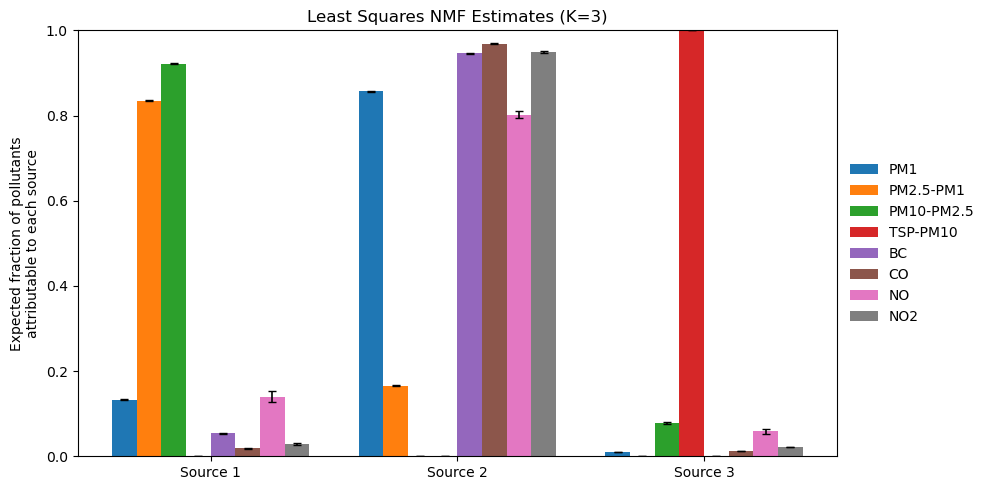

In [9]:
plot_C_matrix_grouped_by_k(
    results_boots["C_hat_NMF"], 
    title="Least Squares NMF Estimates (K=3)", 
    col_label=col_label, 
    # savepath="results/CB/figure/CB_nonegpm25mpm1_LSNMF_K3_bootstrap_Phi.png"
)

In [10]:
# # Bootstrap 
# # With penalty
# results_boots2 = {
#     "seed": np.full(n_reps, np.nan, dtype=float),
#     "time_NMF": np.full(n_reps, np.nan, dtype=float),
#     "C_hat_NMF": np.empty((n_reps, J, K), dtype=float),
# }

# for rep in range(n_reps): 
#     print(f"\n=== Running {rep+1}th experiment ===")
#     seed_rep = seed+rep
#     rng = np.random.default_rng(seed_rep)
#     results_boots2["seed"][rep] = seed_rep

#     # resample
#     idx = rng.integers(0, n, size=n)
#     Yb = np.asarray(Y)[idx] 
#     rb = Yb.sum(axis=1, keepdims=True)
#     Yb_star = Yb / rb

#     # NMF
#     start = time.time()
#     nmf_model = NMF(
#         n_components=K,
#         init="nndsvda",          # good default for nonnegative data
#         random_state=seed_rep,   # tie to bootstrap seed for reproducibility
#         max_iter=1000,
#         tol=1e-4, 
#         alpha_W = 0.01, 
#         alpha_H = 0.01, 
#         l1_ratio = 0 # all L2 penalty - dense solution
#     )

#     Wb = nmf_model.fit_transform(Yb_star)  # shape: (n, K)
#     Hb = nmf_model.components_            # shape: (K, J)
    
#     ## make Hb row-stochastic and adjust Wb accordingly 
#     H_rs = Hb.sum(axis=1, keepdims=True)  # shape (K, 1)
#     H_star_hat_NMF = Hb/H_rs            # each row sums to 1
#     W_star_hat_NMF = Wb*H_rs.T          # scale columns of Wb

#     ## to make sure W_star_hat is row stochastic
#     W_rs = W_star_hat_NMF.sum(axis=1, keepdims=True)
#     W_star_hat_NMF = W_star_hat_NMF/W_rs
#     W_tilde_hat_NMF = W_star_hat_NMF * rb     
#     mu_tilde_hat_NMF = W_tilde_hat_NMF.mean(axis=0)
#     C_hat_NMF = compute_C(mu_tilde_hat_NMF, H_star_hat_NMF)
#     end = time.time()
#     results_boots2["time_NMF"][rep] = end - start

#     # permute
#     H_star_hat_perm_NMF, mu_tilde_hat_perm_NMF, C_hat_perm_NMF, order = permute_estimates_to_match_truth(H_star, H_star_hat_NMF, mu_tilde_hat_NMF, C_hat_NMF)
#     results_boots2["C_hat_NMF"][rep] = np.asarray(C_hat_perm_NMF)

# dump(results_boots2, outdir/"CB_nonegpm25mpm1_LSNMF_penalty_K3_100bootstraps.joblib")   

In [11]:
results_boots2 = load(outdir/"CB_nonegpm25mpm1_LSNMF_penalty_K3_100bootstraps.joblib")   

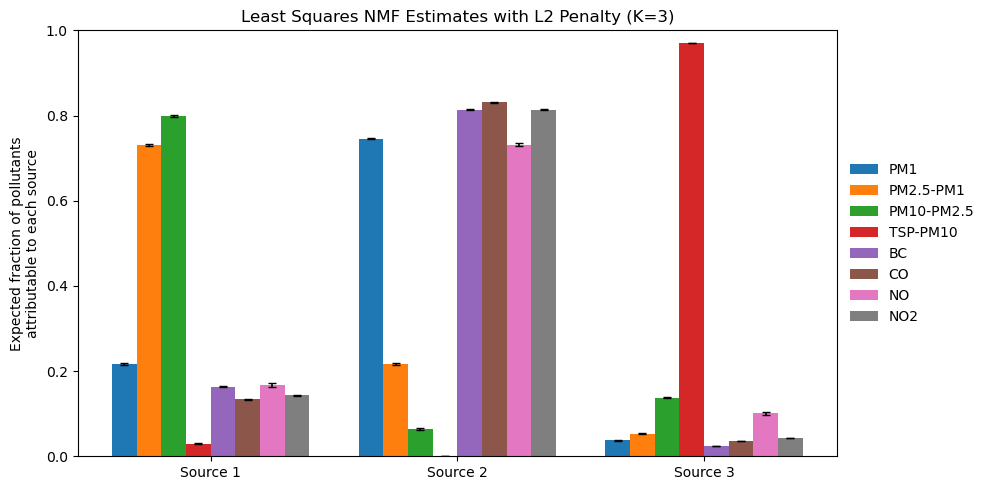

In [12]:
plot_C_matrix_grouped_by_k(
    results_boots2["C_hat_NMF"], 
    title="Least Squares NMF Estimates with L2 Penalty (K=3)", 
    col_label=col_label, 
    # savepath="results/CB/figure/CB_nonegpm25mpm1_penalty_LSNMF_K3_bootstrap_Phi.png"
)